# Concept Questions

1. What is the purpose of a loss function?
2. True or False:
    
    a. A higher loss function means better performance.

    b. The model only updates parameters once each epoch.

    c. The model parameters update based on the gradient of the loss function.

    d. Cross entropy loss is often used for classification.

3. Why do we use cross entropy loss when training GPT?

4. What are the inputs to cross entropy loss?

1. The loss function is used to optimize the model, as update the model parameters based on the gradient of the loss function with respect to the model parameters. (New parameters = old parameters - learning rate * gradient)

2.

  a. False. A lower loss function means better performance.

  b. False. The model updates after each batch.

  c. True.

  d. True.

3. GPT is actually performing classifcation. When GPT-2 generates a new token, it chooses one out of the 50257 tokens in the vocabulary dictionary.

4. Cross entropy loss takes as input the model's output logits and the label (correct answer).

# Training GPT-2

## Preliminaries

Recall our GPT-2 model:

In [ ]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.d_in = config["n_embd"]
        self.d_out = config["n_embd"]
        self.num_heads = config["n_heads"]
        self.d_head = self.d_out // self.num_heads # Dimension of each head
        self.context_length = config["context_length"]
        self.W_query = nn.Linear(self.d_in, self.d_out, bias=config["qkv_bias"])
        self.W_key = nn.Linear(self.d_in, self.d_out, bias=config["qkv_bias"])
        self.W_value = nn.Linear(self.d_in, self.d_out, bias=config["qkv_bias"])
        self.dropout = nn.Dropout(config["dropout_rate"])
        causal_mask = torch.tril(torch.ones(self.context_length, self.context_length))
        self.projection = nn.Linear(self.d_out, self.d_out)

        self.register_buffer("mask", causal_mask)

    def forward(self, x):
        B, N, D = x.shape
        Q = self.W_query(x)
        K = self.W_key(x)
        V = self.W_value(x)

        Q = Q.view(B, N, self.num_heads, self.d_head).transpose(1, 2)
        K = K.view(B, N, self.num_heads, self.d_head).transpose(1, 2)
        V = V.view(B, N, self.num_heads, self.d_head).transpose(1, 2)

        QKT = Q @ K.transpose(2, 3)
        masked_QKT = QKT.masked_fill(self.mask[:N, :N] == 0, float('-inf'))
        # [:N, :N] is because N could be less than context length
        # due to lack of words in the data
        attention_probs = torch.softmax(masked_QKT / (self.d_head ** 0.5), dim=-1)
        attention_probs = self.dropout(attention_probs)

        context_vector = attention_probs @ V
        context_vector = context_vector.transpose(1, 2).contiguous().view(B, N, self.d_out)
        return self.projection(context_vector)

class FeedForward(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(config["n_embd"], 4 * config["n_embd"]),
                                    nn.GELU(),
                                    nn.Linear(4 * config["n_embd"], config["n_embd"]))

    def forward(self, x):
        return self.layers(x)

class LayerNorm(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(config["n_embd"]))
        self.beta = nn.Parameter(torch.zeros(config["n_embd"]))
        self.eps = 1e-5

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        x = (x - mean) / (std + self.eps) # Normalize
        x = self.gamma * x + self.beta # Apply linear function
        return x

class TransformerBlock(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config)
        self.attn = MultiHeadAttention(config)
        self.dropout = nn.Dropout(config["dropout_rate"])
        self.ff = FeedForward(config)
        self.ln2 = LayerNorm(config)

    def forward(self, x):
        # x -> Layer norm 1 -> attention -> dropout -> residual connection
        saved_x = x
        x = self.ln1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = saved_x + x # residual connection

        # x -> Layer norm 2 -> feed forward -> dropout -> residual connection
        saved_x = x
        x = self.ln2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = saved_x + x # residual connection

        # You can do the above with two lines:
        # x = x + self.dropout(self.attn(self.ln1(x)))
        # x = x + self.dropout(self.ff(self.ln2(x)))
        return x

class Simple_GPT(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_embedding = nn.Embedding(config["vocab_size"], config["n_embd"])
        self.position_embedding = nn.Embedding(config["context_length"], config["n_embd"])
        self.dropout = nn.Dropout(config["dropout_rate"])
        self.blocks = nn.Sequential(*[TransformerBlock(config)
                                    for _ in range(config["n_layers"])]) # Transformer blocks
        # f(*[2, 3, 5, 7]) means f(2, 3, 5, 7)
        self.ln_f = LayerNorm(config) # Final layer norm
        self.prediction_layer = nn.Linear(config["n_embd"], config["vocab_size"])
        # Linear mapping to vocab size

        # Register buffer torch.arange(N) to prevent issues with device
        self.register_buffer("pos_range", torch.arange(config["context_length"]))

    def forward(self, x):
        B, N = x.shape      # B is batch size, N is context length
        token_embeddings = self.token_embedding(x)  # [B, N, n_embd]
        position_embeddings = self.position_embedding(self.pos_range[:N])  # [N, n_embd]
        x = token_embeddings + position_embeddings  # Full embeddings; [B, N, n_embd]
        x = self.dropout(x)  # Apply dropout
        x = self.blocks(x)  # Apply transformer blocks; [B, N, n_embd]
        x = self.ln_f(x) # Final layer norm
        logits = self.prediction_layer(x)   # [B, N, vocab_size]
        return logits

In [ ]:
config = {
    "vocab_size": 50257,
    "context_length": 1024,
    "n_embd": 768,
    "n_heads": 12,
    "n_layers": 12,
    "dropout_rate": 0.0,
    "qkv_bias": False
}

When training our GPT-2 model, we want to use a GPU. A device of `cuda` indicates that we are using a GPU, while a device of `cpu` indicates we are using CPU. It is important to not mix tensors of CPU and GPU together.

In [ ]:
a = torch.tensor([1, 3, 7, 6, 4])
print(a.device) # By default tensors are on cpu
b = torch.zeros(5)
print(b.device) # Also cpu

c = torch.tensor([1, 3, 7, 6, 4]).to("cuda")
print(c.device) # cuda:0

d = torch.zeros(5).to("cuda")
print(d.device)

print(a + b) # cpu + cpu allowed
print(c + d) # cuda:0 + cuda:0 allowed
# print(a + c) # error; cpu + cuda:0 not allowed

cpu
cpu
cuda:0
cuda:0
tensor([1., 3., 7., 6., 4.])
tensor([1., 3., 7., 6., 4.], device='cuda:0')


We will be using the `cuda` device.

In [ ]:
device = "cuda"

In [ ]:
input = torch.randint(0, 50257, (1, 1024)).to(device)
print(input.shape)
model = Simple_GPT(config)
model.to(device) # Transforms all model parameters to cuda
output = model(input)
print(output.shape)

torch.Size([1, 1024])
torch.Size([1, 1024, 50257])


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 163059793


In [ ]:
for p in model.parameters():
    print(p)
    break

Parameter containing:
tensor([[-0.9976, -0.6201, -0.5656,  ..., -0.9757, -0.7084,  1.4369],
        [-1.3415,  0.4505,  0.8072,  ..., -0.6188,  0.1700,  0.3107],
        [ 0.4737, -2.5312,  0.1473,  ...,  0.1643,  0.0438,  1.2710],
        ...,
        [-0.1993, -0.7095, -0.5522,  ...,  1.1349, -1.0602,  0.4220],
        [ 1.4440, -0.5257,  0.4968,  ...,  0.9701,  1.4827,  1.8857],
        [ 1.5300,  1.2000, -1.2643,  ..., -0.0913, -0.8255, -2.5068]],
       device='cuda:0', requires_grad=True)


Recall the text generation process:

In [ ]:
def generate_text_sample(model, idx, max_new_tokens, context_length):
    # max_new_tokens is the number of tokens we want to generate
    # idx is the array of indices in the current context
    # idx has size [batch_size, n_tokens]
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_length:]     # Takes the latest context window
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]       #   last token in new context window
        # we want to keep batch and vocab dimension same
        probs = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)     # dim=1 for the context window
    return idx

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
start_token = "Hello, I am"
encoded = torch.tensor(tokenizer.encode(start_token)).unsqueeze(0).to(device)
print(encoded)

tensor([[15496,    11,   314,   716]], device='cuda:0')


Currently, the model is untrained, so we will be getting nonsense tokens as output.

In [ ]:
model.eval()
output = generate_text_sample(model, encoded, 60, config['context_length'])
print(output.shape)
decoded = tokenizer.decode(output[0].squeeze(0).tolist())
print(decoded)

torch.Size([1, 64])
Hello, I ammosp stroke Earn Astrorosis shouldersosta Miss mere Thailandrec Think nig motivations activity Ports Hand somewretch inserts Ars Section continuously̶ miscarriage lackEver babys diagonal deductible ContentgregationMHzvesotional278Fontparen Charm Ultraoooooooooooooooo hydrogenopt Frances New Dep love DexterityprogressFORMDecember──guns vantageReallyRaven Errorurance354 Physics


In order to train our model, we need data. A dataset class and a dataloader function will be helpful.

In [ ]:
from torch.utils.data import Dataset, DataLoader
# Dataset class
class MyData(Dataset):
    # Init function, called when the dataset is created
    # dataset = MyData(text, tokenizer, context_length=4, stride=1)
    def __init__(self, text, tokenizer, context_length, stride=1):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(text)
        for i in range(0, len(token_ids) - context_length, stride):
            self.input_ids.append(torch.tensor(token_ids[i : i + context_length]))
            self.target_ids.append(torch.tensor(token_ids[i + 1 : i + context_length + 1]))

    # Length function
    # len(dataset)
    def __len__(self):
        return len(self.input_ids)

    # Get item function
    # dataset[idx]
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def my_batch(text, batch_size, context_length, stride, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create the dataset object
    dataset = MyData(text, tokenizer, context_length, stride)

    # Use the DataLoader library to create a dataloader that batches the data
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last,
                            num_workers=num_workers)

    return dataloader

In [ ]:
text = "Hello my name is Daniel Li and I am currently teaching how to build an LLM"
dataloader = my_batch(text, batch_size=2, context_length=4, stride=1, shuffle=False)
for batch in dataloader:
    # print(batch)
    input = batch[0]    # 2x4 tensor where 2 is batch size and 4 is context length
    target = batch[1]
    # print(input)
    # print(target)


for input, target in dataloader:
    pass
    # print(input)
    # print(target)

We will be using the cross entropy loss function to train our model.

In [ ]:
# Suppose vocab size is 4
example_logits_1 = torch.tensor([4., 7., 6., 3.]) # Each component corresponds to a token
example_logits_2 = torch.tensor([2., 4., 6., 8.])
example_label = torch.tensor(1) # The correct answer; token index 1
example_loss_1 = nn.functional.cross_entropy(example_logits_1, example_label)
example_loss_2 = nn.functional.cross_entropy(example_logits_2, example_label)
print(example_loss_1)
print(example_loss_2)
# Note that the first tensor has lower loss because it is closer to the correct answer
# (it assigned higher probability to the correct answer)


example_logits_3 = torch.randn(2, 4, 10) # Batch size 2, context size 4, vocab size 10
example_target = torch.tensor([
    [1, 5, 7, 6],
    [0, 6, 1, 6]
])
# We want to flatten the batch and context size since nn.functional.cross_entropy
# doesn't support tensors with more than 2 dimensions
example_loss_3 = nn.functional.cross_entropy(example_logits_3.flatten(0, 1), example_target.flatten())
print(example_loss_3)

tensor(0.3618)
tensor(4.1451)
tensor(2.9467)


**Exercise 1:** Fill in missing parts of the loss function code.

In [ ]:
def calculate_loss(dataloader, model, device="cpu", num_batches=None): # 1 epoch average loss
    # number of batches in dataset is not included as a dimension in any tensor
    if num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))
    model.eval()
    total_loss = 0.0
    for i, (input, target) in enumerate(dataloader): # i is batch index
        if i >= num_batches:
            break

        input = input.to(device) # Move input to appropriate device
        logits = model(input) # Obtain output logits of the model
        target = target.to(device) # Move target to appropriate device

        loss = nn.functional.cross_entropy(logits.flatten(0, 1), target.flatten()) # Use cross entropy loss
        # cross_entropy takes in 2D tensor for logits
        # and 1D tensor for targets

        total_loss += loss.item()
        # .item() extracts a numerical value from a 0D scalar tensor
    return total_loss / num_batches # len(dataloader) is number of batches

In [ ]:
calculate_loss(dataloader, model, device=device)

10.883869489034018

Testing the loss function on longer text:

In [ ]:
text_long = (text + " ") * 20
dataloader_large = my_batch(text_long, batch_size=10, context_length=256, stride=1)

In [ ]:
calculate_loss(dataloader_large, model, device=device)

10.797617316246033

## Training

In [ ]:
GPT_CONFIG_124M = {
    'vocab_size': 50257,
    'context_length': 256,
    'n_embd': 768,
    'n_heads': 12,
    'n_layers': 12,
    'dropout_rate': 0.1,
    'qkv_bias': False,
    'device': 'cuda'
}

In [ ]:
with open('training_data.txt', 'r', encoding="utf-8") as file:
    text_data = file.read()

In [ ]:
print(text_data)

Call me Ishmael. Some years ago—never mind how long precisely—having little or no money in my purse, and nothing particular to interest me on shore, I thought I would sail about a little and see the watery part of the world. It is a way I have of driving off the spleen and regulating the circulation. Whenever I find myself growing grim about the mouth; whenever it is a damp, drizzly November in my soul; whenever I find myself involuntarily pausing before coffin warehouses, and bringing up the rear of every funeral I meet; and especially whenever my hypos get such an upper hand of me, that it requires a strong moral principle to prevent me from deliberately stepping into the street, and methodically knocking people’s hats off—then, I account it high time to get to sea as soon as I can. This is my substitute for pistol and ball. With a philosophical flourish Cato throws himself upon his sword; I quietly take to the ship. There is nothing surprising in this. If they but knew it, almost al

Split the data into training and validation data:

In [ ]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]
#train_data
val_data

'delusion that it was a choice resulting from my own unbiased freewill and discriminating judgment.\n\nChief among these motives was the overwhelming idea of the great whale himself. Such a portentous and mysterious monster roused all my curiosity. Then the wild and distant seas where he rolled his island bulk; the undeliverable, nameless perils of the whale; these, with all the attending marvels of a thousand Patagonian sights and sounds, helped to sway me to my wish. With other men, perhaps, such things would not have been inducements; but as for me, I am tormented with an everlasting itch for things remote. I love to sail forbidden seas, and land on barbarous coasts. Not ignoring what is good, I am quick to perceive a horror, and could still be social with it—would they let me—since it is but well to be on friendly terms with all the inmates of the place one lodges in.\n\nBy reason of these things, then, the whaling voyage was welcome; the great flood-gates of the wonder-world swung

In [ ]:
print(len(text_data))
print(len(train_data))
print(len(val_data))

12183
10964
1219


Creating dataloaders:

In [ ]:
train_dataloader = my_batch(train_data, batch_size=6,
                            context_length=GPT_CONFIG_124M['context_length'] // 2,
                            stride=GPT_CONFIG_124M['context_length'] // 2,
                            shuffle=True, drop_last=True, num_workers=0)

val_dataloader = my_batch(val_data, batch_size=6,
                          context_length=GPT_CONFIG_124M['context_length'] // 2,
                          stride=GPT_CONFIG_124M['context_length'] // 2,
                          shuffle=False, drop_last=False, num_workers=0)

In [ ]:
for x, y in train_dataloader:
    print(x.shape, y.shape)

torch.Size([6, 128]) torch.Size([6, 128])
torch.Size([6, 128]) torch.Size([6, 128])
torch.Size([6, 128]) torch.Size([6, 128])


Useful helper function that can convert text into token IDs:

In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    return torch.tensor(encoded).unsqueeze(0) #unsqueeze adds batch dimension 1

In [ ]:
print(text_to_token_ids('equirfo ebruifeqwiof ewq', tokenizer))

tensor([[ 4853,   343,  6513, 36649,   622,   901,    80,    86,   952,    69,
           304,    86,    80]])


Helper function used to generate and print the output:

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.position_embedding.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_sample(model, encoded, 50, context_size)
    decoded = tokenizer.decode(token_ids[0].squeeze(0).tolist())
    print(decoded.replace("\n", " "))
    model.train()

Helper function used to get loss values for the train and validation splits:

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calculate_loss(train_loader, model, device, eval_iter)
        val_loss = calculate_loss(val_loader, model, device, eval_iter)
    model.train()
    return train_loss, val_loss

**Exercise 2:** Fill in missing parts of the training loop.

In [ ]:
def training_loop(model, train_dataloader, val_dataloader,
                  optimizer, device, num_epochs,
                  eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train() # Puts the model in training mode
        for input_batch, target_batch in train_dataloader:
            optimizer.zero_grad() # Zeros gradient calculations

            input_batch = input_batch.to(device) # Move to proper device
            target_batch = target_batch.to(device) # Move to proper device
            logits = model(input_batch)
            loss = nn.functional.cross_entropy(logits.flatten(0, 1),
                                               target_batch.flatten())

            # we are updating based on single batch here
            loss.backward() # computes the gradients
            optimizer.step() # updates the model parameters (optimizer is linked to model)
            # forward means passing through the model
            # backward means I compute the gradient of the loss wrt the parameters
            # Update by -lr * gradient

            tokens_seen += input_batch.numel() # number of elements
            # train_losses.append(loss.item())
            global_step += 1 # number of batches trained
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_dataloader, val_dataloader, device, eval_iter)
                val_losses.append(val_loss)
                train_losses.append(train_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f},"
                      f"Val loss {val_loss:.3f}")

        # Generate and print a sample for each epoch:
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

**Exercise 3:** Create a GPT-2 model using `GPT_CONFIG_124M`. Then, train the model by running a training loop. Use `eval_freq=1`, `eval_iter=5`, and choose your own starting context (4-5 words).

In [ ]:
torch.manual_seed(123)
model = Simple_GPT(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 20
start_context = "Once upon a time," # Replace
train_losses, val_losses, tokens_seen = training_loop(
    model, train_dataloader, val_dataloader, optimizer, device, num_epochs,
    eval_freq=1, eval_iter=5, start_context=start_context, tokenizer=tokenizer
) # Run the training loop

Epoch 1 (Step 000000): Train loss 9.565,Val loss 9.889
Epoch 1 (Step 000001): Train loss 9.048,Val loss 9.339
Epoch 1 (Step 000002): Train loss 8.731,Val loss 9.047
Once upon a time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch 2 (Step 000003): Train loss 8.443,Val loss 8.819
Epoch 2 (Step 000004): Train loss 8.103,Val loss 8.607
Epoch 2 (Step 000005): Train loss 7.703,Val loss 8.404
Once upon a time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch 3 (Step 000006): Train loss 7.347,Val loss 8.206
Epoch 3 (Step 000007): Train loss 7.051,Val loss 8.029
Epoch 3 (Step 000008): Train loss 6.655,Val loss 7.871
Once upon a time, and the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the, and the
Epoch 4 (Step 000009): Train loss 6.372,Val loss 7.764
Epoch 4 (Step 000010): Train loss 5.902,Val loss 7.701
Epoch 4 (Step 000011): Train loss 5.555,Val 

Plotting the loss function over time:

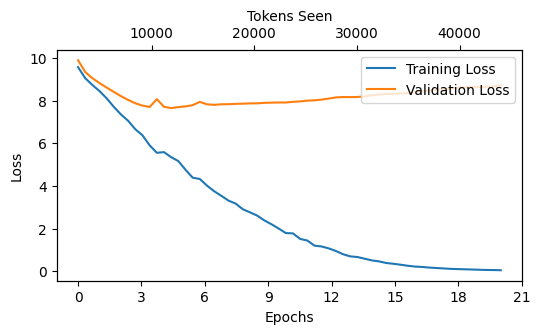

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(6, 3))
    ax1.plot(epochs_seen, train_losses, color='tab:blue', label='Training Loss')
    ax1.plot(epochs_seen, val_losses, color='tab:orange', label='Validation Loss', linestyle='-')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, color='tab:blue', alpha=0)
    ax2.set_xlabel("Tokens Seen")
    ax2.set_xlim(tokens_seen[0], tokens_seen[-1])
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

**Exercise 4:** Train another GPT-2 model on another dataset. Use a train ratio of 0.8. You are allowed to use functions already defined above.

In [ ]:
my_config = {
    'vocab_size': 50257,
    'context_length': 256,
    'n_embd': 768,
    'n_heads': 12,
    'n_layers': 12,
    'dropout_rate': 0.1,
    'qkv_bias': False,
    'device': 'cuda'
}

In [ ]:
with open('training_data_3.txt', 'r', encoding="utf-8") as file:
    text_data_2 = file.read()

train_ratio = 0.8
split_idx = int(train_ratio * len(text_data_2))
train_data_2 = text_data_2[:split_idx]
val_data_2 = text_data_2[split_idx:]

train_dataloader_2 = my_batch(train_data_2, batch_size=20,
                            context_length=my_config['context_length'] // 2,
                            stride=my_config['context_length'] // 2,
                            shuffle=True, drop_last=True, num_workers=0)

val_dataloader_2 = my_batch(val_data_2, batch_size=20,
                          context_length=my_config['context_length'] // 2,
                          stride=my_config['context_length'] // 2,
                          shuffle=False, drop_last=False, num_workers=0)

model_2 = Simple_GPT(my_config)
model_2.to(my_config["device"])

optimizer_2 = torch.optim.AdamW(model_2.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 20
start_context = "Once upon a time," # Replace

train_losses, val_losses, tokens_seen = training_loop(
    model_2, train_dataloader_2, val_dataloader_2, optimizer_2,
    my_config["device"], num_epochs,
    eval_freq=1, eval_iter=5, start_context=start_context, tokenizer=tokenizer
) # Run the training loop


Epoch 1 (Step 000000): Train loss 9.788,Val loss 9.843
Epoch 1 (Step 000001): Train loss 9.300,Val loss 9.339
Epoch 1 (Step 000002): Train loss 8.987,Val loss 9.068
Epoch 1 (Step 000003): Train loss 8.652,Val loss 8.766
Epoch 1 (Step 000004): Train loss 8.346,Val loss 8.479
Epoch 1 (Step 000005): Train loss 8.060,Val loss 8.215
Epoch 1 (Step 000006): Train loss 7.816,Val loss 7.967
Epoch 1 (Step 000007): Train loss 7.548,Val loss 7.743
Epoch 1 (Step 000008): Train loss 7.329,Val loss 7.551
Epoch 1 (Step 000009): Train loss 7.169,Val loss 7.386
Epoch 1 (Step 000010): Train loss 6.985,Val loss 7.251
Epoch 1 (Step 000011): Train loss 6.910,Val loss 7.152
Epoch 1 (Step 000012): Train loss 6.733,Val loss 7.080
Once upon a time, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,
Epoch 2 (Step 000013): Train loss 6.714,Val loss 7.035
Epoch 2 (Step 000014): Train loss 6.645,Val loss 7.015
Epoch 2 (Step 000015): Train los